In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
from torch.utils.data import DataLoader, TensorDataset

import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.calibration import calibration_curve

In [23]:
df = pd.read_csv('winequality-red.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [24]:
target_variable = 'quality'

# Encoding the label 
categories = list(np.unique(df[target_variable]))
X = df.drop(columns=[target_variable]).values
y = df[target_variable].values

le = LabelEncoder()
y = le.fit_transform(y)

# normalize variables
scaler = StandardScaler()
X = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Convert data to the PyTorch format, PyTorch works with Tensor data type:
# Since my data is not complex, I can use torch.float32 data type
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test =  torch.tensor(X_test, dtype=torch.float32)
X_val =  torch.tensor(X_val, dtype=torch.float32)

# Target value :
# For target value, I need torch.long data type because target value is not continuous value
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)



train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64, shuffle=False)

# Hyperparameter

In [25]:
# Distribution Mean:
# Adjust the mean of the distribution to be 0, the model learns nearly to 0 (Symmetric), it is good to avoid model from bias.
mu = 0
# Noise Standard Deviation:
# This parameter is used to control the amount of randomness in the model. 
sigma = 0.7

# LK regularization:
# This parameter is used to measures difference between the learning weight and the prior distribution
# This regularization controls divergence to balance simplicity and data fit. 
lambda_kl = 0.1
# Monte Carlo Samples:
# This controls the number of samples used to estimate the uncertainty. Sample is number of forward passes through the model.
mc_samples_eval = 50

bb_learning_rate = 0.0005

# L2 regularization:
bnn_wight_decay  = 0.0001

# Define the Bayesian NN

In [26]:
# I will define the class for the model.
class BayesianNN(nn.Module):
    def __init__(self, input_shape, output_shape, mu = 0, sigma = 0.5):
        super().__init__()
        
        # Define the layers with probabilistic of weights
        self.fc1 = bnn.BayesLinear(prior_mu=mu, prior_sigma = sigma, in_features=input_shape, out_features=128)
        self.fc2 = bnn.BayesLinear(prior_mu=mu, prior_sigma = sigma, in_features=128, out_features=64)
        self.fc3 = bnn.BayesLinear(prior_mu=mu, prior_sigma = sigma, in_features =64, out_features = 32)
        self.fc4 = bnn.BayesLinear(prior_mu=mu, prior_sigma = sigma, in_features =32, out_features = 16)
        self.fc5 = bnn.BayesLinear(prior_mu=mu, prior_sigma = sigma, in_features =16, out_features = output_shape)
        self.relu = nn.ReLU()
        
        
        # Adjust the dropout rate:
        self.dropout = nn.Dropout(0.3)
        
        
        # Activation and Normalization:
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.batch_norm3 = nn.BatchNorm1d(32)
        self.batch_norm4 = nn.BatchNorm1d(16)
        
        
    
      # Forward pass:
      # Defining how the data will pass through the network
    def forward (self, x, mc_dropout = False):
            # if mc_dropout is true, dropout is applied  for uncertain estimation
            # fc1 applies probabilistic weights to input 
            x = self.batch_norm1(self.relu(self.fc1(x)))
            x = self.dropout(x) if mc_dropout else x
            x = self.batch_norm2(self.relu(self.fc2(x)))
            x = self.dropout(x) if mc_dropout else x
            x = self.batch_norm3(self.relu(self.fc3(x)))
            x = self.dropout(x) if mc_dropout else x
            x = self.batch_norm4(self.relu(self.fc4(x)))
            x = self.dropout(x) if mc_dropout else x
            # fc5 gives unnormalized scores for classification
            return self.fc5(x)

# Hyperparameters and model initialization

In [27]:
# Define the model:
model = BayesianNN(input_shape = X.shape[1], output_shape=len(np.unique(y)), sigma=0.4)

# Loss function(nn.CrossEntropyLoss): 
# CrossEntropyLoss is used for multi-class classification problems.
# The loss function is used to measure the difference between the predicted and actual values.
criterion = nn.CrossEntropyLoss()

# Bayesian Kullback-Leibler Divergence Loss:
# This loss function is used to measure the difference between the predicted and actual distributions.
bkl_loss = bnn.BKLLoss(reduction = 'mean')

# AdamW optimizer:
# This optimizer is like Adam optimizer but it has weight decay regularization.
optimizer = optim.AdamW(model.parameters(), lr=bb_learning_rate, weight_decay= 0.0001)

#  Create train/evaluate -functions for BNN training/evaluation

In [28]:
#Create a function with uncertainty estimation:

def evaluate (model, loader, mc_samples=mc_samples_eval):
    model.eval()
    total_correct = 0
    total_samples = 0
    total_loss = 0
    uncertainties = []
    
    
    with torch.no_grad():
        for X_batch, y_batch in loader:
            # Get the model predictions with Monte Carlo Dropout
            outputs_list  = [model(X_batch, mc_dropout=True) for _ in range(mc_samples)]
            outputs_stack = torch.stack(outputs_list)
            
            
            # average predictions over standard deviation
            outputs_mean = outputs_stack.mean(dim=0)
            outputs_std = outputs_stack.std(dim=0)
            
            
            loss = criterion(outputs_mean, y_batch)
            total_loss += loss.item() 
            
            probs = torch.softmax(outputs_mean, dim=1)
            preds = torch.argmax(probs, dim=1)
            
            total_correct += (preds == y_batch).sum().item()
            total_samples += y_batch.size(0)
            
            
            uncertainties.extend(outputs_std.mean(dim = 1).cpu().numpy())
            
    accuracy_score  = total_correct / total_samples
    nll = total_loss / len(loader)
    avg_uncertainty = np.mean(uncertainties)
    
    
    print(f"Accuracy: {accuracy_score:.4f}, val_loss: {nll:.4f}, Uncertainty: {avg_uncertainty:.4f}")
    
    return accuracy_score, nll, avg_uncertainty, uncertainties

# Training the model with BKLLoss:

def train(model, loader, epochs):
    model.train()
    history = {}
    history['train_loss'] = []
    history['val_loss'] = []
    history['val_accuracy'] = []
    history['avg_uncertainty'] = []
    
    
    
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in loader:
            optimizer.zero_grad()
            outputs = model(X_batch, mc_dropout=True)
            
            
            
            ce_loss = criterion(outputs, y_batch)
            kl_loss = bkl_loss(model)
            loss = ce_loss + lambda_kl * kl_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
            
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_loss/len(loader):.4f}")
        val_accuracy, val_loss, avg_uncertainty, __ = evaluate(model, val_loader)
        history['train_loss'].append(total_loss/len(loader))
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
        history['avg_uncertainty'].append(avg_uncertainty)
        
        model.train()
        
    return history
        

# TRAIN THE BNN MODEL

In [29]:
# train the model (fit), epochs are usually 1000-5000 with BNN classification
history = train(model, train_loader, epochs=2500)

Epoch 1/2500, Train Loss: 2.9938
Accuracy: 0.2375, val_loss: 1.7423, Uncertainty: 1.3109
Epoch 2/2500, Train Loss: 2.9189
Accuracy: 0.1000, val_loss: 1.8071, Uncertainty: 1.2114
Epoch 3/2500, Train Loss: 3.0456
Accuracy: 0.2062, val_loss: 1.7383, Uncertainty: 1.1800
Epoch 4/2500, Train Loss: 3.0081
Accuracy: 0.1562, val_loss: 1.7119, Uncertainty: 1.1782
Epoch 5/2500, Train Loss: 2.7557
Accuracy: 0.2500, val_loss: 1.6813, Uncertainty: 1.1542
Epoch 6/2500, Train Loss: 2.7673
Accuracy: 0.2125, val_loss: 1.7144, Uncertainty: 1.1249
Epoch 7/2500, Train Loss: 2.8584
Accuracy: 0.1125, val_loss: 1.7556, Uncertainty: 1.1586
Epoch 8/2500, Train Loss: 2.8398
Accuracy: 0.2250, val_loss: 1.6980, Uncertainty: 1.1451
Epoch 9/2500, Train Loss: 2.6497
Accuracy: 0.3312, val_loss: 1.6156, Uncertainty: 1.1082
Epoch 10/2500, Train Loss: 2.6324
Accuracy: 0.2062, val_loss: 1.7138, Uncertainty: 1.1026
Epoch 11/2500, Train Loss: 2.7289
Accuracy: 0.4188, val_loss: 1.6157, Uncertainty: 1.0557
Epoch 12/2500, Trai

# Error metrics

In [30]:
# get predictions 
model.eval()
y_true = y_test.cpu().numpy()
y_pred = []
y_pred_probs = []


with torch.no_grad():
  for X_batch, _ in test_loader:
        # get average output, average of 10 predictions for each sample
        outputs_list = [model(X_batch, mc_dropout=True) for _ in range(10)]
        outputs_stacks = torch.stack(outputs_list)
        outputs_means = outputs_stacks.mean(dim=0)
        preds = torch.argmax(outputs_means, dim=1)
        probs = torch.softmax(outputs_means, dim=1)
        y_pred_probs.extend(probs.cpu().numpy())    
        y_pred.extend(preds.cpu().numpy())

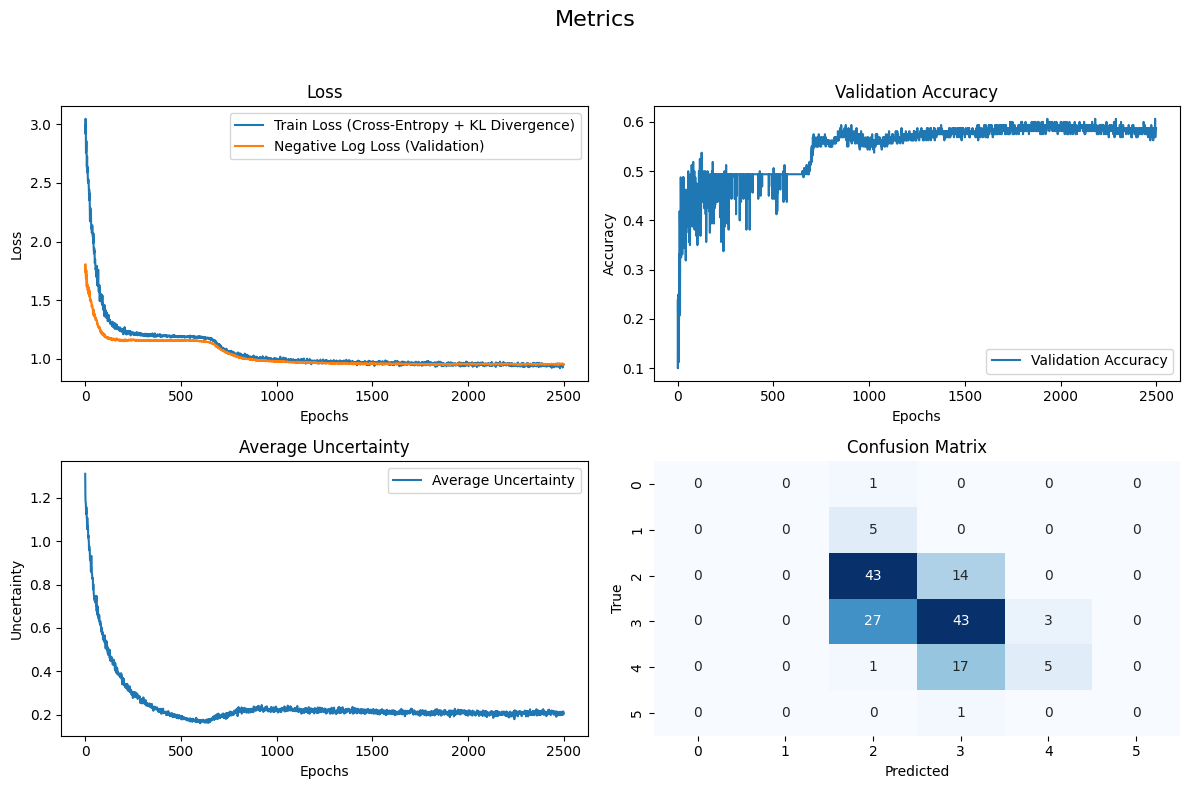

In [31]:
# plot training history
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plt.suptitle('Metrics', fontsize=16)

# BNN, losses
axes[0, 0].plot(history['train_loss'], label='Train Loss (Cross-Entropy + KL Divergence)')
axes[0, 0].plot(history['val_loss'], label='Negative Log Loss (Validation)')
axes[0, 0].set_title('Loss')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# accuracy
axes[0, 1].plot(history['val_accuracy'], label='Validation Accuracy')
axes[0, 1].set_title('Validation Accuracy')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

# uncertainty
axes[1, 0].plot(history['avg_uncertainty'], label='Average Uncertainty')
axes[1, 0].set_title('Average Uncertainty')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Uncertainty')
axes[1, 0].legend()

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1], vmax=cm.max(), cbar=False)
axes[1, 1].set_title('Confusion Matrix')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('True')

# combine the four plots into one and show
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [32]:
# the usual classification report 
print(classification_report(y_true, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         5
           2       0.56      0.75      0.64        57
           3       0.57      0.59      0.58        73
           4       0.62      0.22      0.32        23
           5       0.00      0.00      0.00         1

    accuracy                           0.57       160
   macro avg       0.29      0.26      0.26       160
weighted avg       0.55      0.57      0.54       160



In [33]:
mse = mean_squared_error(y_true, y_pred)
print(f"MSE: {mse:.4f}")

MSE: 0.4875


In [34]:
def get_mc_dropout_predictions(model, dataloader, num_samples = 100):
    model.eval()
    model.train()
    
    
    all_probs = []
    all_labels =[]
    
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            batch_probs = []
            
            for __ in range(num_samples):
                outputs  = model(inputs)
                prob = torch.softmax(outputs, dim = 1).cpu().numpy()
                batch_probs.append(prob)
                
                
            # calculate mean probabilities 
            avg_probs = np.mean(batch_probs, axis = 0)
            all_probs.append(avg_probs)
            all_labels.append(labels.cpu().numpy())
            
    return np.vstack(all_probs), np.hstack(all_labels)



# helper function to actually plot the calibration curve

def plot_calibration_curve(model, dataloader, num_samples = 100, bins=10):
    
    probs, labels = get_mc_dropout_predictions(model, dataloader, num_samples)
    # take max probability and corresponding true class
    confidence = np.max(probs, axis = 1)
    predictions = np.argmax(probs, axis = 1)
    
    correct = 
    
    # compute the calibration curve 
    fraction_of_positives, mean_predicted_value = calibration_curve(correct, confidence, n_bins=bins)

SyntaxError: invalid syntax (246643199.py, line 38)